In [23]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
from keras.utils import to_categorical
from sklearn.utils import shuffle
import cv2
import glob2

In [2]:
# loading data

X_train = np.zeros((990,12288))
Y_train = np.zeros((990,1))

X_test = np.zeros((95,12288))
Y_test = np.zeros((95,1))

X_train[0:272,:] = np.loadtxt('bicycle0.txt')
Y_train[0:272,0] = np.loadtxt('bicycle1.txt')

X_train[272:747,:] = np.loadtxt('car0.txt')
Y_train[272:747,0] = np.loadtxt('car1.txt')

X_train[747:990,:] = np.loadtxt('motorbike0.txt')
Y_train[747:990,0] = np.loadtxt('motorbike1.txt')

X_test[0:28,:] = np.loadtxt('bictest0.txt')
Y_test[0:28,0] = np.loadtxt('bictest1.txt')

X_test[28:69,:] = np.loadtxt('cartest0.txt')
Y_test[28:69,0] = np.loadtxt('cartest1.txt')

X_test[69:95,:] = np.loadtxt('motortest0.txt')
Y_test[69:95,0] = np.loadtxt('motortest1.txt')


X_train,Y_train = shuffle(X_train,Y_train,random_state = 0)
X_test,Y_test = shuffle(X_test,Y_test,random_state = 0)

X_train = np.reshape(X_train,(990,64,64,3))
X_test = np.reshape(X_test,(np.shape(X_test)[0],64,64,3))

Y_train = to_categorical(Y_train,3)
Y_test = to_categorical(Y_test, 3)

# Normalizing the training dataset
X_train = X_train/255
X_test = X_test/255


In [3]:
def identity_block(X, f, filters, stage, block):
   
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
   
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
   
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
   
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [11]:
def ResNet50(input_shape = (64, 64, 3), classes = 3):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2),name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [12]:
class_model = ResNet50(input_shape = (64, 64, 3), classes = 3)

In [13]:
class_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
class_model.fit(x=X_train,y=Y_train,epochs =50,batch_size = 50)

Epoch 1/50
990/990 [==============================] - 354s 357ms/step - loss: 1.1723 - acc: 0.4455
Epoch 2/50
990/990 [==============================] - 310s 313ms/step - loss: 1.0603 - acc: 0.4586
Epoch 3/50
990/990 [==============================] - 301s 304ms/step - loss: 1.0482 - acc: 0.4556
Epoch 4/50
990/990 [==============================] - 302s 305ms/step - loss: 1.0557 - acc: 0.4697
Epoch 5/50
990/990 [==============================] - 302s 306ms/step - loss: 1.0431 - acc: 0.4566
Epoch 6/50
990/990 [==============================] - 301s 304ms/step - loss: 1.0452 - acc: 0.4667
Epoch 7/50
990/990 [==============================] - 301s 305ms/step - loss: 1.0422 - acc: 0.4687
Epoch 8/50
990/990 [==============================] - 301s 304ms/step - loss: 1.0401 - acc: 0.4687
Epoch 9/50
990/990 [==============================] - 300s 303ms/step - loss: 1.0336 - acc: 0.4667
Epoch 10/50
990/990 [==============================] - 301s 304ms/step - loss: 1.0208 - acc: 0.4677
Epoch 11/

In [15]:
prediction = class_model.evaluate(x=X_test,y=Y_test)
print()
print("loss = " + str(prediction[0]))
print("accuracy = " + str(prediction[1]))

95/95 [==============================] - 10s 103ms/step

loss = 2.3582367897
accuracy = 0.599999994981


The image shows a car


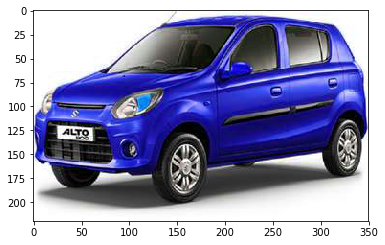

In [35]:
img_path = 'C:/Users/Abbas Shah/maruti-suzuki-alto-800.jpg'
x=np.zeros((1,64,64,3))
img=cv2.imread(img_path,1)
img_re=cv2.resize(img,(64,64))
x[0,:,:,:]=img_re[:,:,:]
imshow(img)
x = x/255
pred=class_model.predict(x)
idx = np.argmax(pred)
if(idx==0):
    print('The image shows a bicycle')
if(idx==1):
    print('The image shows a car')
if(idx==2):
    print('The image shows a motorbike')